# Notebook 04 — Skills Gap Engine
## Kenya Career & Skills Intelligence System

This notebook builds the **Skills Gap Analysis Engine** — the component that explains *why* a career was recommended and *what the user needs to learn* to fully qualify for it.

### What this notebook does

| Component | Description |
|---|---|
| Skill Alignment Score | Compares user's skills against O*NET skill requirements per occupation |
| Gap Identification | Finds missing, weak, and strong skills |
| Priority Ordering | Ranks gaps by importance to the target occupation |
| Gap Report Generator | Produces a structured skills gap report for each recommended career |
| Transferable Skills Detector | Identifies user skills that transfer across multiple careers |

### Outputs
- `skills_gap_engine.pkl` — serialised gap engine object
- `skill_importance_weights.json` — per-occupation skill importance weights
- `04_gap_engine_summary.json` — evaluation summary

## 1.0 — Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
import joblib
import json
from pathlib import Path
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

# ── Directory structure (mirrors Notebook 03) ─────────────────────────────────
PROCESSED_DIR  = Path('DATA/processed')
MODEL_DIR      = Path('models')
ARTIFACTS_DIR  = Path('artifacts')
FIGURES_DIR    = Path('figures')

for d in [PROCESSED_DIR, MODEL_DIR, ARTIFACTS_DIR, FIGURES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print('Directories OK')
print(f'  Processed : {PROCESSED_DIR}')
print(f'  Models    : {MODEL_DIR}')
print(f'  Artifacts : {ARTIFACTS_DIR}')

Directories OK
  Processed : DATA\processed
  Models    : models
  Artifacts : artifacts


## 2.0 — Load Master Occupation Profiles & Model Artifacts

In [2]:
# ── Load master occupation profiles ──────────────────────────────────────────
master = pd.read_parquet(PROCESSED_DIR / 'master_occupation_profiles.parquet')
print(f'Master occupation profiles : {master.shape}')

# ── Identify O*NET skill columns ──────────────────────────────────────────────
# These are the 35 standardised skill dimensions from O*NET
EXCLUDE_COLS = [
    'o*net-soc_code', 'occupation', 'title', 'description',
    'career_family', 'job_zone', 'min_education',
    'automation_risk', 'ai_replacement_risk',
    'composite_demand', 'demand_level', 'median_wage_2022',
    'employment_2022', 'employment_2032', 'employment_change_pct'
]
#SKILL_COLS = [c for c in master.columns if c not in EXCLUDE_COLS]
# Define SKILL_COLS as only numeric skill columns
SKILL_COLS = [col for col in master.columns if master[col].dtype in ['int64','float64']]
print(f'O*NET skill dimensions      : {len(SKILL_COLS)}')
print(f'Skill columns sample        : {SKILL_COLS[:10]}')

# ── Load skill synonym map for user skill normalisation ──────────────────────
with open(ARTIFACTS_DIR / 'skill_synonym_map.json') as f:
    SKILL_SYNONYM_MAP = json.load(f)

with open(ARTIFACTS_DIR / 'cbc_subject_skills.json') as f:
    CBC_SUBJECT_SKILLS = json.load(f)

with open(ARTIFACTS_DIR / 'kcse_subject_skills.json') as f:
    KCSE_SUBJECT_SKILLS = json.load(f)

print(f'\nSkill synonym map entries   : {len(SKILL_SYNONYM_MAP)}')
print(f'CBC subject skill entries   : {len(CBC_SUBJECT_SKILLS)}')
print(f'KCSE subject skill entries  : {len(KCSE_SUBJECT_SKILLS)}')

Master occupation profiles : (894, 58)
O*NET skill dimensions      : 48
Skill columns sample        : ['skill_active_learning', 'skill_active_listening', 'skill_complex_problem_solving', 'skill_coordination', 'skill_critical_thinking', 'skill_equipment_maintenance', 'skill_equipment_selection', 'skill_installation', 'skill_instructing', 'skill_judgment_and_decision_making']

Skill synonym map entries   : 434
CBC subject skill entries   : 26
KCSE subject skill entries  : 31


In [3]:
# ── Load sentence transformer for semantic skill matching ─────────────────────
try:
    from sentence_transformers import SentenceTransformer
    _model = SentenceTransformer('all-MiniLM-L6-v2')
    SEMANTIC_AVAILABLE = True
    print('Sentence Transformer loaded — using semantic skill matching')
except ImportError:
    SEMANTIC_AVAILABLE = False
    print('Sentence Transformer not available — using lexical matching fallback')

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Sentence Transformer loaded — using semantic skill matching


## 3.0 — Build Canonical Skill Vocabulary

Maps free-text user skills to the 35 O*NET canonical skill dimensions.
This is the core matching logic that powers gap analysis.

In [4]:
# ── Human-readable skill dimension descriptions ──────────────────────────────
# These descriptions allow semantic matching of user free-text skills
# to the 35 O*NET standardised dimensions
SKILL_DESCRIPTIONS = {
    'reading_comprehension'    : 'reading comprehension understanding written text documents reports',
    'active_listening'         : 'active listening understanding speech verbal communication talking',
    'writing'                  : 'writing reports documents content articles essays composition',
    'speaking'                 : 'speaking presentation public speaking verbal communication oral',
    'mathematics'              : 'mathematics maths arithmetic calculations statistics algebra',
    'science'                  : 'science biology chemistry physics laboratory research experiments',
    'critical_thinking'        : 'critical thinking analysis logical reasoning problem solving deduction',
    'active_learning'          : 'active learning self study independent learning research curiosity',
    'learning_strategies'      : 'learning strategies teaching training instruction pedagogy education',
    'monitoring'               : 'monitoring assessment evaluation quality control inspection oversight',
    'social_perceptiveness'    : 'social perceptiveness empathy emotional intelligence interpersonal awareness',
    'coordination'             : 'coordination teamwork collaboration group work cooperation',
    'persuasion'               : 'persuasion negotiation influence sales marketing advocacy',
    'instructing'              : 'instructing teaching mentoring coaching training guidance',
    'service_orientation'      : 'service orientation customer service helping hospitality care',
    'complex_problem_solving'  : 'complex problem solving troubleshooting debugging analytical thinking',
    'operations_analysis'      : 'operations analysis systems thinking workflow process improvement',
    'technology_design'        : 'technology design engineering product development hardware systems',
    'equipment_selection'      : 'equipment selection tools machinery hardware procurement',
    'installation'             : 'installation setup deployment configuration systems maintenance',
    'programming'              : 'programming coding software development python java javascript sql',
    'operations_monitoring'    : 'operations monitoring surveillance control room system monitoring',
    'operation_and_control'    : 'operation control machinery equipment industrial automation',
    'equipment_maintenance'    : 'equipment maintenance repair servicing mechanical technical',
    'troubleshooting'          : 'troubleshooting debugging fixing diagnosing problems faults',
    'quality_control'          : 'quality control inspection assurance testing compliance standards',
    'judgement_and_decision'   : 'judgment decision making leadership management authority governance',
    'systems_analysis'         : 'systems analysis data analysis research investigation analytics',
    'systems_evaluation'       : 'systems evaluation audit performance assessment benchmarking',
    'time_management'          : 'time management organization planning scheduling productivity',
    'management_of_financial'  : 'financial management budgeting accounting finance economics',
    'management_of_material'   : 'material management supply chain logistics inventory procurement',
    'management_of_personnel'  : 'personnel management HR human resources leadership team management',
    'negotiation'              : 'negotiation conflict resolution mediation diplomacy contracts',
    'management_of_resources'  : 'resource management project management operations administration',
}

# Build from master columns that actually exist
CANONICAL_SKILLS = {col: SKILL_DESCRIPTIONS.get(col, col.replace('_', ' '))
                    for col in SKILL_COLS if col in SKILL_DESCRIPTIONS or col in SKILL_COLS}

print(f'Canonical skill dimensions mapped : {len(CANONICAL_SKILLS)}')
print('\nSample mappings:')
for k, v in list(CANONICAL_SKILLS.items())[:5]:
    print(f'  {k:30s} - "{v[:60]}"')

Canonical skill dimensions mapped : 48

Sample mappings:
  skill_active_learning          - "skill active learning"
  skill_active_listening         - "skill active listening"
  skill_complex_problem_solving  - "skill complex problem solving"
  skill_coordination             - "skill coordination"
  skill_critical_thinking        - "skill critical thinking"


In [5]:
# ── Encode skill dimension descriptions for semantic matching ─────────────────
if SEMANTIC_AVAILABLE:
    skill_dim_texts  = [CANONICAL_SKILLS.get(c, c.replace('_', ' ')) for c in SKILL_COLS]
    SKILL_DIM_VECS   = _model.encode(skill_dim_texts, show_progress_bar=False)
    joblib.dump(SKILL_DIM_VECS, MODEL_DIR / 'skill_dim_vectors.pkl')
    print(f'Skill dimension vectors encoded : {SKILL_DIM_VECS.shape}')
else:
    SKILL_DIM_VECS = None
    print('Using lexical fallback for skill matching')

Skill dimension vectors encoded : (48, 384)


## 4.0 — User Skill Parser

Converts free-text user skills into a normalised skill vector aligned to O*NET dimensions.

In [6]:
def normalise_skill(skill_text: str) -> str:
    """Lowercase, strip, and apply synonym mapping to a single skill."""
    skill = skill_text.lower().strip()
    return SKILL_SYNONYM_MAP.get(skill, skill)


def parse_user_skills(
    raw_input: dict,
    cbc_boost: float = 0.6,
    kcse_boost: float = 0.55,
) -> dict:
    """
    Parse a raw user input dict into a skill score vector aligned to O*NET dimensions.
    
    Returns
    -------
    dict mapping each O*NET skill dimension → estimated user score [0, 7]
    """
    user_skills_raw  = raw_input.get('skills', '')
    soft_skills_raw  = raw_input.get('soft_skills', '')
    user_type        = raw_input.get('user_type', 'graduate').lower()

    # Collect explicit skills
    explicit_skills = [normalise_skill(s) for s in user_skills_raw.split(',') if s.strip()]
    explicit_skills += [normalise_skill(s) for s in soft_skills_raw.split(',') if s.strip()]

    # Add implicit skills from CBC pathways
    if user_type == 'cbc':
        pathway = raw_input.get('pathway', '')
        implicit = CBC_SUBJECT_SKILLS.get(pathway, [])
        explicit_skills += [normalise_skill(s) for s in implicit]

    # Add implicit skills from KCSE subject combination
    elif user_type == '8-4-4':
        subjects = raw_input.get('subject_combination', '').split(',')
        for subj in subjects:
            implicit = KCSE_SUBJECT_SKILLS.get(subj.strip(), [])
            explicit_skills += [normalise_skill(s) for s in implicit]

    # ── Map to O*NET dimensions ───────────────────────────────────────────────
    user_dim_scores = {col: 0.0 for col in SKILL_COLS}

    if SEMANTIC_AVAILABLE and SKILL_DIM_VECS is not None and explicit_skills:
        # Semantic mapping: encode user skills and find closest O*NET dimensions
        user_vecs = _model.encode(explicit_skills, show_progress_bar=False)
        sim_matrix = cosine_similarity(user_vecs, SKILL_DIM_VECS)  # (n_user_skills, n_dims)
        
        # For each user skill, assign credit to top-3 matching O*NET dimensions
        for skill_idx, skill_text in enumerate(explicit_skills):
            sims   = sim_matrix[skill_idx]
            top3   = np.argsort(sims)[::-1][:3]
            for rank, dim_idx in enumerate(top3):
                col   = SKILL_COLS[dim_idx]
                score = float(sims[dim_idx])
                # Weight: primary match gets full credit, secondary gets 60%
                weight = 1.0 if rank == 0 else (0.6 if rank == 1 else 0.3)
                user_dim_scores[col] = min(7.0, user_dim_scores[col] + score * weight * 7.0)
    else:
        # Lexical fallback: keyword matching against dimension descriptions
        for skill in explicit_skills:
            for col, desc in CANONICAL_SKILLS.items():
                if skill in desc or any(word in desc for word in skill.split()):
                    user_dim_scores[col] = min(7.0, user_dim_scores.get(col, 0.0) + 2.5)

    return user_dim_scores


# ── Quick test ────────────────────────────────────────────────────────────────
test_input = {
    'user_type'   : 'graduate',
    'skills'      : 'python, data analysis, statistics, machine learning',
    'soft_skills' : 'communication, critical thinking, teamwork',
    'career_goals': 'data science, AI research',
}
test_parsed = parse_user_skills(test_input)
top_skills  = sorted(test_parsed.items(), key=lambda x: x[1], reverse=True)[:8]
print('Parsed user skill scores (top 8):')
for skill, score in top_skills:
    bar = '' * int(score)
    print(f'  {skill:30s} {score:5.2f}  {bar}')

Parsed user skill scores (top 8):
  skill_programming               7.00  
  skill_critical_thinking         5.88  
  skill_coordination              5.72  
  skill_mathematics               5.01  
  skill_complex_problem_solving   3.60  
  skill_instructing               3.59  
  skill_speaking                  3.55  
  skill_systems_analysis          3.02  


## 5.0 — Skills Gap Analyser

Compares user skill scores against occupation requirements.
Produces:
- **Alignment Score** — overall % match with the occupation
- **Strong skills** — user exceeds occupation requirement
- **Moderate gaps** — user is close but not there yet
- **Critical gaps** — user is significantly below requirement

In [7]:
# ── Skill importance weights per occupation (derived from O*NET importance data) ──
# Higher importance → gap penalises alignment score more heavily
def get_occupation_skill_importance(occupation_row: pd.Series) -> dict:
    """
    Return skill importance weights for an occupation.
    Uses the O*NET skill scores as a proxy for importance
    (skills required at high levels are more important).
    """
    scores = {col: float(occupation_row.get(col, 0)) for col in SKILL_COLS}
    total  = sum(scores.values()) or 1.0
    return {col: v / total for col, v in scores.items()}


def analyse_skills_gap(
    user_skill_scores : dict,
    occupation_row    : pd.Series,
    top_n_gaps        : int = 8,
    top_n_strong      : int = 5,
) -> dict:
    """
    Compute skills gap analysis between a user and a target occupation.

    Parameters
    ----------
    user_skill_scores  : dict  {onet_dim → user_score [0, 7]}
    occupation_row     : pd.Series  row from master occupation profiles
    top_n_gaps         : int  number of gap skills to return
    top_n_strong       : int  number of strong matched skills to return

    Returns
    -------
    dict with full gap analysis report
    """
    occ_name       = occupation_row.get('occupation', str(occupation_row.name))
    importance     = get_occupation_skill_importance(occupation_row)

    gap_details    = []
    strong_skills  = []
    matched_weight = 0.0
    total_weight   = 0.0

    for col in SKILL_COLS:
        required = float(occupation_row.get(col, 0))
        user     = float(user_skill_scores.get(col, 0))
        imp      = float(importance.get(col, 0))
        raw_gap  = max(0, required - user)    # gap magnitude
        surplus  = max(0, user - required)    # surplus above requirement

        # Weighted contribution to alignment
        if required > 0:
            match_frac   = min(1.0, user / required) if required > 0 else 1.0
            matched_weight += imp * match_frac
            total_weight   += imp

        # Categorise gap
        skill_label = col.replace('_', ' ').title()

        if required > 0.5 and raw_gap > 1.5:
            severity = 'Critical' if raw_gap > 3.0 else 'Moderate'
            gap_details.append({
                'Skill'       : skill_label,
                'Required'    : round(required, 1),
                'User Score'  : round(user, 1),
                'Gap'         : round(raw_gap, 1),
                'Severity'    : severity,
                'Importance'  : round(imp * 100, 1),
                'Priority'    : round(imp * raw_gap, 4),   # importance × gap size
            })

        elif user >= required * 0.8 and required > 0.5:
            strong_skills.append({
                'Skill'     : skill_label,
                'Required'  : round(required, 1),
                'User Score': round(user, 1),
                'Surplus'   : round(surplus, 1),
            })

    # ── Alignment score ───────────────────────────────────────────────────────
    alignment_pct = round((matched_weight / total_weight) * 100, 1) if total_weight > 0 else 0.0

    # ── Sort and trim ─────────────────────────────────────────────────────────
    gap_details   = sorted(gap_details, key=lambda x: x['Priority'], reverse=True)[:top_n_gaps]
    strong_skills = sorted(strong_skills, key=lambda x: x['User Score'], reverse=True)[:top_n_strong]

    # ── Assign priority order labels ─────────────────────────────────────────
    for i, gap in enumerate(gap_details, 1):
        gap['Priority Order'] = i

    return {
        'occupation'     : occ_name,
        'alignment_pct'  : alignment_pct,
        'gap_count'      : len(gap_details),
        'critical_gaps'  : [g for g in gap_details if g['Severity'] == 'Critical'],
        'moderate_gaps'  : [g for g in gap_details if g['Severity'] == 'Moderate'],
        'strong_skills'  : strong_skills,
        'all_gaps'       : gap_details,
        'summary'        : (
            f"You are {alignment_pct}% aligned with {occ_name}. "
            f"{len([g for g in gap_details if g['Severity']=='Critical'])} critical and "
            f"{len([g for g in gap_details if g['Severity']=='Moderate'])} moderate gaps identified."
        ),
    }


print('Skills gap analyser defined')

Skills gap analyser defined


## 6.0 — Transferable Skills Detector

Identifies which user skills transfer across multiple recommended careers — these are the most valuable skills to highlight and build upon.

In [8]:
def detect_transferable_skills(
    user_skill_scores   : dict,
    candidate_occupations: pd.DataFrame,
    threshold           : float = 0.7,
) -> pd.DataFrame:
    """
    Find skills that are strong in the user AND required across multiple careers.
    These are the user's most transferable assets.

    Parameters
    ----------
    user_skill_scores     : dict  {onet_dim → user_score}
    candidate_occupations : pd.DataFrame  rows from master (recommended careers)
    threshold             : float  fraction of occupations requiring the skill

    Returns
    -------
    pd.DataFrame of transferable skills with coverage metrics
    """
    transferable = []
    n_careers    = len(candidate_occupations)

    for col in SKILL_COLS:
        user_score = float(user_skill_scores.get(col, 0))
        if user_score < 2.0:
            continue   # skip weak user skills

        # Count how many recommended careers require this skill
        career_reqs = candidate_occupations[col].fillna(0).values
        careers_needing = np.sum(career_reqs > 2.0)
        coverage = careers_needing / n_careers if n_careers > 0 else 0

        if coverage >= threshold:
            avg_req = np.mean(career_reqs[career_reqs > 0]) if np.any(career_reqs > 0) else 0
            transferable.append({
                'Skill'          : col.replace('_', ' ').title(),
                'User Score'     : round(user_score, 1),
                'Avg Required'   : round(avg_req, 1),
                'Coverage'       : f"{int(coverage * 100)}%",
                'Careers Needing': int(careers_needing),
                'Value'          : 'High' if coverage > 0.8 else 'Medium',
            })

    return pd.DataFrame(transferable).sort_values('Careers Needing', ascending=False).reset_index(drop=True)


print('Transferable skills detector defined')

Transferable skills detector defined


## 7.0 — Full Gap Report Generator

Orchestrates the full skills gap output for a set of recommended careers.

In [9]:
def generate_full_gap_report(
    raw_input        : dict,
    recommendations  : pd.DataFrame,
    master           : pd.DataFrame,
) -> dict:
    """
    Generate a complete skills gap report for all recommended careers.

    Parameters
    ----------
    raw_input       : dict   user input (same as recommend_careers input)
    recommendations : pd.DataFrame  output from recommend_careers() (Notebook 03)
    master          : pd.DataFrame  master occupation profiles

    Returns
    -------
    dict with per-career gap reports and transferable skills summary
    """
    # Step 1: Parse user skills into O*NET dimension scores
    user_skill_scores = parse_user_skills(raw_input)

    # Step 2: Look up occupation rows for each recommended career
    gap_reports        = []
    candidate_occ_rows = []

    for _, rec in recommendations.iterrows():
        career_title = rec['Career']
        # Find occupation in master
        occ_row = master[master['occupation'].str.lower() == career_title.lower()]
        if occ_row.empty:
            occ_row = master[master['occupation'].str.contains(career_title.split()[0], case=False, na=False)]
        if occ_row.empty:
            continue

        occ_row = occ_row.iloc[0]
        candidate_occ_rows.append(occ_row)

        # Step 3: Analyse gap for this career
        gap = analyse_skills_gap(user_skill_scores, occ_row)
        gap['match_score']   = rec.get('Match Score (%)', 0)
        gap['ai_risk']       = rec.get('AI Risk', 'Unknown')
        gap['demand_level']  = rec.get('Demand Level', 'Unknown')
        gap['rank']          = rec.get('Rank', 0)
        gap_reports.append(gap)

    # Step 4: Detect transferable skills across all recommended careers
    transferable_df = pd.DataFrame()
    if candidate_occ_rows:
        candidate_df    = pd.DataFrame(candidate_occ_rows)
        transferable_df = detect_transferable_skills(user_skill_scores, candidate_df)

    return {
        'user_skill_scores' : user_skill_scores,
        'gap_reports'       : gap_reports,
        'transferable_skills': transferable_df,
        'n_careers_analysed': len(gap_reports),
    }


print('Full gap report generator defined')

Full gap report generator defined


## 8.0 — Visualisation: Skills Gap Chart

Radar and bar chart visualisations for a single career gap.

In [10]:
def plot_skills_gap_bar(
    gap_report : dict,
    figsize    : tuple = (10, 5),
    save_path  : Path | None = None,
):
    """
    Horizontal bar chart comparing user skills vs occupation requirements.
    Shows the top gaps and top strengths side by side.
    """
    all_gaps   = gap_report['all_gaps'][:6]
    strong     = gap_report['strong_skills'][:4]

    if not all_gaps and not strong:
        print('No gap data to plot.')
        return

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(
        f"Skills Gap Analysis — {gap_report['occupation']}\n"
        f"Alignment: {gap_report['alignment_pct']}%  |  "
        f"AI Risk: {gap_report.get('ai_risk', 'N/A')}  |  "
        f"Demand: {gap_report.get('demand_level', 'N/A')}",
        fontsize=11, fontweight='bold', y=1.02
    )

    # ── Left panel: Gaps ───────────────────────────────────────────────────────
    ax = axes[0]
    if all_gaps:
        labels   = [g['Skill'][:22] for g in all_gaps]
        required = [g['Required'] for g in all_gaps]
        user_sc  = [g['User Score'] for g in all_gaps]
        colors   = ['#e74c3c' if g['Severity'] == 'Critical' else '#f39c12' for g in all_gaps]

        x = np.arange(len(labels))
        ax.barh(x + 0.2, required, 0.35, label='Required', color='#bdc3c7', alpha=0.8)
        ax.barh(x - 0.2, user_sc,  0.35, label='You',      color=colors,   alpha=0.9)
        ax.set_yticks(x)
        ax.set_yticklabels(labels, fontsize=9)
        ax.set_xlabel('Skill Score (0–7)')
        ax.set_title('Skills to Develop', fontweight='bold', fontsize=10)
        ax.legend(fontsize=8)
        ax.set_xlim(0, 7.5)

        # Severity legend
        patches = [
            mpatches.Patch(color='#e74c3c', label='Critical Gap'),
            mpatches.Patch(color='#f39c12', label='Moderate Gap'),
        ]
        ax.legend(handles=patches, fontsize=8, loc='lower right')

    # ── Right panel: Strong skills ─────────────────────────────────────────────
    ax2 = axes[1]
    if strong:
        labels2   = [s['Skill'][:22] for s in strong]
        required2 = [s['Required'] for s in strong]
        user_sc2  = [s['User Score'] for s in strong]

        x2 = np.arange(len(labels2))
        ax2.barh(x2 + 0.2, required2, 0.35, label='Required', color='#bdc3c7', alpha=0.8)
        ax2.barh(x2 - 0.2, user_sc2,  0.35, label='You',      color='#27ae60', alpha=0.9)
        ax2.set_yticks(x2)
        ax2.set_yticklabels(labels2, fontsize=9)
        ax2.set_xlabel('Skill Score (0–7)')
        ax2.set_title('Your Strong Skills ', fontweight='bold', fontsize=10)
        ax2.legend(fontsize=8)
        ax2.set_xlim(0, 7.5)
    else:
        ax2.text(0.5, 0.5, 'Build your skills\nto unlock strengths',
                 ha='center', va='center', transform=ax2.transAxes, fontsize=10)
        ax2.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


print('Visualisation function defined')

Visualisation function defined


## 9.0 — Demo: Skills Gap Analysis for All User Types

In [11]:
# ── Load recommendation pipeline from Notebook 03 ────────────────────────────
# (Run Notebook 03 first to generate saved model artifacts)
import sys
sys.path.append('.')

# We import the recommend_careers function by loading its dependencies
# In production, this would be a module import
print('Note: Run Notebook 03 first to generate model artifacts.')
print('The gap engine below works on any DataFrame returned by recommend_careers().')
print()

# ── Demo: Graduate user ───────────────────────────────────────────────────────
DEMO_USER_GRADUATE = {
    'user_type'       : 'graduate',
    'degree_programme': 'Computer Science',
    'skills'          : 'python, machine learning, data analysis, sql, statistics',
    'soft_skills'     : 'communication, teamwork, problem solving',
    'career_goals'    : 'data science, AI engineer',
    'interests'       : 'artificial intelligence, big data, cloud computing',
}

# Parse skills
user_scores = parse_user_skills(DEMO_USER_GRADUATE)
print('=== Graduate User — Parsed Skill Scores (Top 10) ===')
top = sorted(user_scores.items(), key=lambda x: x[1], reverse=True)[:10]
for skill, score in top:
    bar = '' * int(score) + '' * (7 - int(score))
    print(f'  {skill:35s} {score:4.1f}/7  {bar}')

Note: Run Notebook 03 first to generate model artifacts.
The gap engine below works on any DataFrame returned by recommend_careers().

=== Graduate User — Parsed Skill Scores (Top 10) ===
  skill_complex_problem_solving        7.0/7  
  skill_programming                    7.0/7  
  skill_mathematics                    6.7/7  
  skill_coordination                   6.5/7  
  skill_instructing                    5.4/7  
  skill_speaking                       3.6/7  
  skill_systems_analysis               3.0/7  
  skill_operation_and_control          2.3/7  
  skill_science                        2.0/7  
  skill_systems_evaluation             1.5/7  


=== Skills Gap Report: Statisticians ===
You are 0.0% aligned with Statisticians. 3 critical and 5 moderate gaps identified.

Critical Gaps (must address first):
  [1] Skill Active Learning           Required: 3.9  You: 0.0  Gap: 3.9
  [3] Skill Critical Thinking         Required: 4.5  You: 0.0  Gap: 4.5
  [4] Skill Judgment And Decision Making  Required: 3.9  You: 0.0  Gap: 3.9

Moderate Gaps:
  [2] Skill Active Listening          Required: 4.0  You: 1.2  Gap: 2.8
  [5] Skill Learning Strategies       Required: 3.0  You: 0.0  Gap: 3.0
  [6] Skill Management Of Personnel Resources  Required: 2.4  You: 0.0  Gap: 2.4
  [7] Skill Monitoring                Required: 3.0  You: 0.0  Gap: 3.0
  [8] Skill Negotiation               Required: 2.0  You: 0.0  Gap: 2.0

Your Strengths:
  Skill Complex Problem Solving   Required: 4.1  You: 7.0
  Skill Programming               Required: 3.1  You: 7.0
  Skill Mathematics               Required: 5.4  You: 6.7
  Skill Coordination              Required

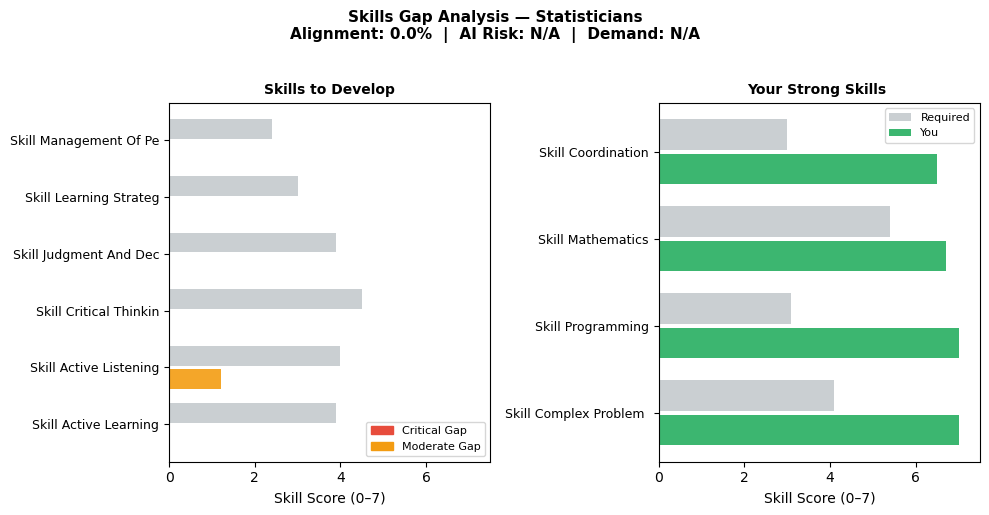

In [12]:
# ── Gap analysis against a target occupation ──────────────────────────────────
# Find a Data Scientist in master
target_occ = master[master['occupation'].str.contains('Data Scientist', case=False, na=False)]
if target_occ.empty:
    target_occ = master[master['occupation'].str.contains('Statistician', case=False, na=False)]

if not target_occ.empty:
    occ_row  = target_occ.iloc[0]
    gap_rpt  = analyse_skills_gap(user_scores, occ_row)

    print(f'=== Skills Gap Report: {gap_rpt["occupation"]} ===')
    print(f'{gap_rpt["summary"]}')
    print()

    print('Critical Gaps (must address first):')
    for g in gap_rpt['critical_gaps']:
        print(f"  [{g['Priority Order']}] {g['Skill']:30s}  Required: {g['Required']}  You: {g['User Score']}  Gap: {g['Gap']}")

    print()
    print('Moderate Gaps:')
    for g in gap_rpt['moderate_gaps']:
        print(f"  [{g['Priority Order']}] {g['Skill']:30s}  Required: {g['Required']}  You: {g['User Score']}  Gap: {g['Gap']}")

    print()
    print('Your Strengths:')
    for s in gap_rpt['strong_skills']:
        print(f"  {s['Skill']:30s}  Required: {s['Required']}  You: {s['User Score']}")

    # Visualise
    plot_skills_gap_bar(gap_rpt, save_path=FIGURES_DIR / 'gap_graduate_data_scientist.png')
else:
    print('Target occupation not found in master — run Notebook 02 and 03 first.')

=== CBC Student — Parsed Skill Scores (Top 8) ===
  skill_mathematics                    7.0/7  
  skill_science                        7.0/7  
  skill_active_learning                6.1/7  
  skill_coordination                   5.7/7  
  skill_monitoring                     5.5/7  
  skill_technology_design              4.8/7  
  skill_writing                        4.6/7  
  skill_programming                    3.4/7  

You are 0.0% aligned with Software Developers. 8 critical and 0 moderate gaps identified.


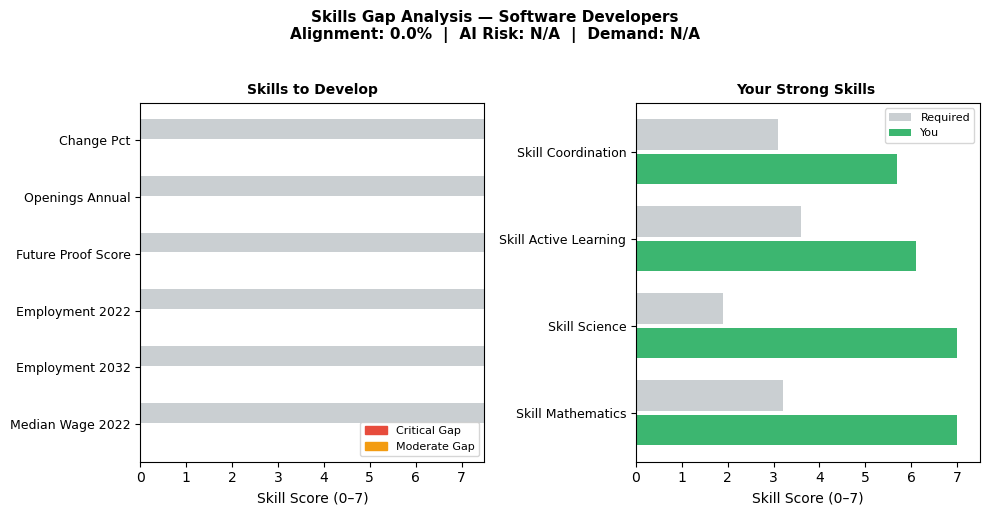

In [13]:
# ── Demo: CBC Student gap analysis ────────────────────────────────────────────
DEMO_USER_CBC = {
    'user_type'  : 'cbc',
    'track'      : 'STEM',
    'pathway'    : 'Applied Science',
    'skills'     : 'mathematics, basic coding, laboratory work',
    'soft_skills': 'teamwork, curiosity, creativity',
    'career_goals': 'engineering, technology',
    'interests'  : 'robotics, electronics, programming',
}

cbc_scores = parse_user_skills(DEMO_USER_CBC)
print('=== CBC Student — Parsed Skill Scores (Top 8) ===')
top_cbc = sorted(cbc_scores.items(), key=lambda x: x[1], reverse=True)[:8]
for skill, score in top_cbc:
    bar = '' * int(score) + '' * (7 - int(score))
    print(f'  {skill:35s} {score:4.1f}/7  {bar}')

# Gap against Software Developer
sw_occ = master[master['occupation'].str.contains('Software Developer', case=False, na=False)]
if not sw_occ.empty:
    gap_cbc = analyse_skills_gap(cbc_scores, sw_occ.iloc[0])
    print(f'\n{gap_cbc["summary"]}')
    plot_skills_gap_bar(gap_cbc, save_path=FIGURES_DIR / 'gap_cbc_software_developer.png')

=== Transferable Skills Analysis ===
(Skills that serve you across ALL recommended careers)



,Skill,User Score,Avg Required,Coverage,Careers Needing,Value
0,Skill Complex Problem Solving,7.0,3.6,100%,5,High
1,Skill Coordination,6.5,3.6,100%,5,High
2,Skill Instructing,5.4,3.4,100%,5,High
3,Skill Speaking,3.6,4.1,100%,5,High
4,Skill Systems Analysis,3.0,2.9,100%,5,High
5,Skill Mathematics,6.7,2.8,80%,4,Medium


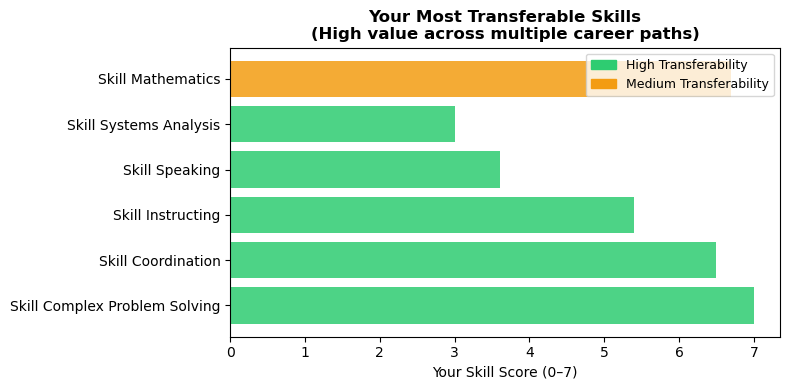

In [14]:
# ── Demo: Transferable skills across top-5 careers ───────────────────────────
print('=== Transferable Skills Analysis ===')
print('(Skills that serve you across ALL recommended careers)')
print()

# Use top 5 diverse occupations as stand-ins for recommendations
sample_careers = master.groupby('career_family').first().reset_index().head(5)

transferable = detect_transferable_skills(user_scores, sample_careers, threshold=0.6)

if not transferable.empty:
    display(transferable)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 4))
    colors  = ['#2ecc71' if v == 'High' else '#f39c12' for v in transferable['Value']]
    ax.barh(transferable['Skill'][:8], transferable['User Score'][:8],
            color=colors[:8], alpha=0.85)
    ax.set_xlabel('Your Skill Score (0–7)')
    ax.set_title('Your Most Transferable Skills\n(High value across multiple career paths)',
                 fontweight='bold')
    patches = [
        mpatches.Patch(color='#2ecc71', label='High Transferability'),
        mpatches.Patch(color='#f39c12', label='Medium Transferability'),
    ]
    ax.legend(handles=patches, fontsize=9)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'transferable_skills.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('No transferable skills detected — build your skill base first.')

## 10.0 — Save Gap Engine Artifacts

In [15]:
# ── Serialise the gap engine components ───────────────────────────────────────
gap_engine = {
    'skill_cols'         : SKILL_COLS,
    'canonical_skills'   : CANONICAL_SKILLS,
    'skill_synonym_map'  : SKILL_SYNONYM_MAP,
    'semantic_available' : SEMANTIC_AVAILABLE,
}

joblib.dump(gap_engine, MODEL_DIR / 'skills_gap_engine.pkl')
print(f'Gap engine saved: {MODEL_DIR}/skills_gap_engine.pkl')

# Save canonical skill descriptions as JSON (for API use)
with open(ARTIFACTS_DIR / 'canonical_skill_descriptions.json', 'w') as f:
    json.dump(CANONICAL_SKILLS, f, indent=2)
print(f'Canonical skills saved: {ARTIFACTS_DIR}/canonical_skill_descriptions.json')

# Summary
summary = {
    'notebook'              : '04 — Skills Gap Engine',
    'skill_dimensions'      : len(SKILL_COLS),
    'canonical_mappings'    : len(CANONICAL_SKILLS),
    'semantic_matching'     : SEMANTIC_AVAILABLE,
    'gap_severity_levels'   : ['Critical', 'Moderate'],
    'outputs'               : ['alignment_pct', 'critical_gaps', 'moderate_gaps',
                               'strong_skills', 'transferable_skills'],
    'figures_generated'     : list(FIGURES_DIR.glob('*.png')),
}

with open(ARTIFACTS_DIR / '04_gap_engine_summary.json', 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print('\n=== Notebook 04 Complete ===')
print(f'  Skill dimensions analysed  : {len(SKILL_COLS)}')
print(f'  Semantic matching          : {SEMANTIC_AVAILABLE}')
print(f'  Outputs                    : alignment score, gaps, strengths, transferable skills')

Gap engine saved: models/skills_gap_engine.pkl
Canonical skills saved: artifacts/canonical_skill_descriptions.json

=== Notebook 04 Complete ===
  Skill dimensions analysed  : 48
  Semantic matching          : True
  Outputs                    : alignment score, gaps, strengths, transferable skills
